# An Investigation into our Vector Velocity Approximation: Problem Statement

We are interested in exploring and validating the following approximation numerically:

$$\bar v(t) = \int_{-\infty}^t e^{-\alpha (t - s)} \dot x (s) ds \\ \approx \frac{1}{n} \sum_{i \in [n]} x_i w_i p(t - t_i)$$

Where $p(t) = \eta_\varepsilon(t - t_i) - \alpha e^{-\alpha t} 1_{\{t \geq 0\}}$, and $w_i$ is the time weighting for a random sample $x_i$, with $i \in [n]$ such that $x(t_i) \approx x_i$.

There are two key approximations which are used the arive at the final equation. They are the following:

$$x(t) \approx \frac{1}{n} \sum_{i \in [n]} \eta_\varepsilon(t - t_i) x_i w_i$$
$$\int_{-\infty}^t e^{-\alpha (t -s)} \eta_\varepsilon (s - t_i) ds \approx e^{-\alpha (t - t_i)} 1_{\{t \geq 0\}}$$

In the second approximation $1_{\{t \geq 0\}}$ is an indicator function which is 1 if $t \geq 0$ and 0 otherwise.

### Key Questions
The following are the key questions we are looking to answer:

1. What is a reasonable method of determining $w_i$?

2. What errors are introduced by the second approximation?

3. How do we determine reasonable values of $\alpha$ and $\epsilon$?

# Question One: $w_i$ and KDEs

Given the approximation $x(t) \approx \frac{1}{n} \sum_{i \in [n]} \eta_\varepsilon(t - t_i) x_i w_i$, how should we set $w_i$?

To test this, lets demonstrate this approximation on easy parameterized function, for various methods of calcuating $w_i$. We will also sample each $x_i$ such that $x(t_i) = x_i$, for simplicity's sake.

The parameterized function we'll use is

$$ f(t) = (t^2, \sin (t))$$

First let's import some useful packages. (I tend to use torch instead of numpy)

In [1]:
from typing import Tuple

import torch
import math
import matplotlib.pyplot as plt

/home/tanner/miniconda3/envs/hatespace/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next we'll define our parameterized function, lets add a couple of additional options so that we can switch it up later.

In [2]:
def f_1(t: float) -> float:
    return t

def f_2(t: float) -> float:
    return t ** 2

def f_3(t: float) -> float:
    return t ** 3

def f_4(t: float) -> float:
    return torch.sin(t)

def parameterized_function(t: float) -> Tuple[float, float]:
    return [f_2(t), f_4(t)]

Now, let's sample randomly from our parameterized function; We'll do so on the interval $[0, 10]$.

Then we can plot our function on that interval, along with our sampled points

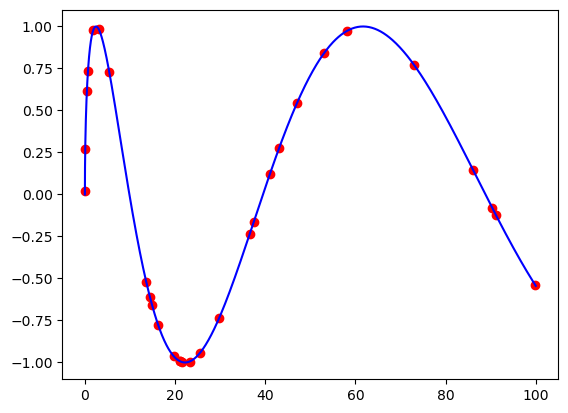

In [3]:
t_range = (0, 10)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plt.plot(uniform_sample_points[0], uniform_sample_points[1], color='blue')
plt.scatter(random_sample_points[0], random_sample_points[1], color='red')

## Example One: No $w_i$ term.

First, we'll run the estimation with $w_i$ fixed at 1. Let's define a function for $\eta_\epsilon(x)$.

In [4]:
SQRT_2PI = torch.sqrt(torch.tensor(2 * torch.pi))

def gaussian(x: float, e: float) -> float:
    exponent = -0.5 * ((x / e) ** 2)
    return torch.exp(exponent) / (e * SQRT_2PI)

Now we can evaluate $x(t) \approx \frac{1}{n} \sum_{i \in [n]} \eta_\varepsilon(t - t_i) x_i$.

So that we can plot our approximation, lets evaluate this for many values of $t$ in our domain. This way, we can visually show an approximation of the smooth function $x(t)$ over $t$.

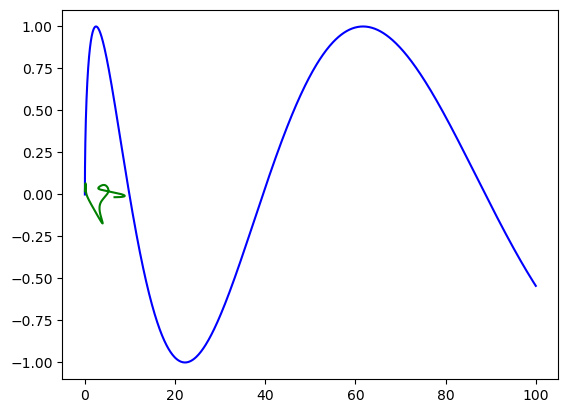

In [5]:
def plot_weight_of_one(uniform_samples, random_samples, kernel_size):
    # Calculate our random sample points
    random_sample_points = parameterized_function(random_samples)
    # Initialize where we will store our approximated x(t) values
    gaussian_estimated_points = []
    # Iterate over our domain of t
    for t in uniform_samples:
        # Initialize where we will store our sum
        estimated_value_at_t = [0, 0]
        # Sum over all samples in [n]
        for t_i, x_i in zip(random_samples, torch.stack(random_sample_points).T):
            # Calculate the gaussian for this sample's t value
            eta_epsilon = gaussian(t_i - t, kernel_size)
            # Multiply by x_i and add to our sum
            estimated_value_at_t[0] += eta_epsilon * x_i[0]
            estimated_value_at_t[1] += eta_epsilon * x_i[1]
        # Divide by n
        estimated_value_at_t[0] /= len(random_samples)
        estimated_value_at_t[1] /= len(random_samples)
        # Add to our list of x(t) outputs
        gaussian_estimated_points.append(estimated_value_at_t)

    # Plot both the true function and our estimated function
    gaussian_estimated_points = torch.tensor(gaussian_estimated_points).T
    plt.plot(uniform_sample_points[0], uniform_sample_points[1], color='blue')
    plt.plot(gaussian_estimated_points[0], gaussian_estimated_points[1], color='green')

plot_weight_of_one(uniform_samples, random_samples, 0.5)

## Example Two: $t_{i+1} - t_i$
Quite a poor approximation... Let's next try using a w_i which is dependant on the distance

$$t_{i+1} - t_i$$

However a better approximation than this is

$$w_i = \frac{t_{i+1} - t_{i-1}}{2}$$

Since it will capture the size of the portions of the domain of $t$ which are closest to $t_i$ for each $t_i$. Note that this will have some special cases when $i = 0$ or $i = |n|$. In these cases, we will take $w_i$ to be $\frac{t_{i+1} - t_i}{2}$ and $\frac{t_i - t_{i-1}}{2}$, respectively.

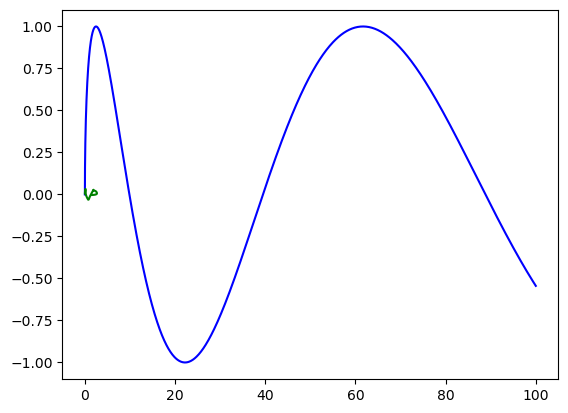

In [6]:
def plot_harmonic_weight(uniform_samples, random_samples, kernel_size, normalize=True):
    # Calculate our random sample points
    random_sample_points = parameterized_function(random_samples)
    random_sample_points = torch.stack(random_sample_points).T
    # Initialize where we will store our approximated x(t) values
    gaussian_estimated_points = []
    # Iterate over our domain of t
    for t in uniform_samples:
        # Initialize where we will store our sum
        estimated_value_at_t = [0, 0]
        # Sum over all samples in [n]
        for i, (t_i, x_i) in enumerate(zip(random_samples, random_sample_points)):
            # Calculate the gaussian for this sample's t value
            eta_epsilon = gaussian(t_i - t, kernel_size)
            # Calculate the w_i term
            if i > 0 and i < len(random_samples) - 1:
                w_i = (random_samples[i + 1] - random_samples[i - 1]) / 2
            elif i == 0:
                w_i = (random_samples[i + 1] - random_samples[i]) / 2
            elif i == len(random_samples) - 1:
                w_i = (random_samples[i] - random_samples[i - 1]) / 2

            # Multiply by x_i and add to our sum
            estimated_value_at_t[0] += eta_epsilon * x_i[0] * w_i
            estimated_value_at_t[1] += eta_epsilon * x_i[1] * w_i
        # Divide by n
        if normalize:
            estimated_value_at_t[0] /= len(random_samples)
            estimated_value_at_t[1] /= len(random_samples)
        # Add to our list of x(t) outputs
        gaussian_estimated_points.append(estimated_value_at_t)

    # Plot both the true function and our estimated function
    gaussian_estimated_points = torch.tensor(gaussian_estimated_points).T
    plt.plot(uniform_sample_points[0], uniform_sample_points[1], color='blue')
    plt.plot(gaussian_estimated_points[0], gaussian_estimated_points[1], color='green')

plot_harmonic_weight(uniform_samples, random_samples, 0.5)

At first glance, this appears to be much worse than our first attempt. However you may notice that the function `plot_harmonic_weight` includes a curious paramter called `normalize`. This parameter simply controls whether or not our sum is divided by $n$. Let's try it without:

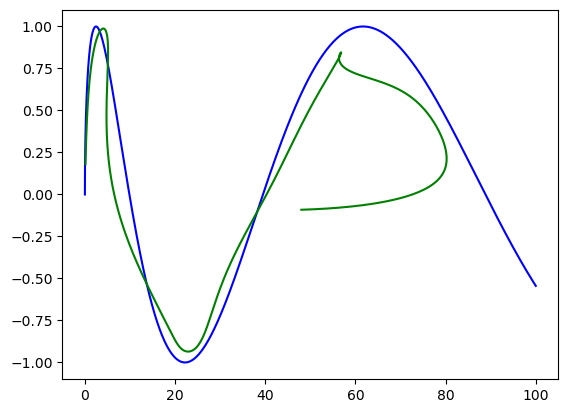

In [7]:
plot_harmonic_weight(uniform_samples, random_samples, 0.5, normalize=False)

Now we begin to see that our approximation matches the function. Let's try this with some other parameterized functions and domains.

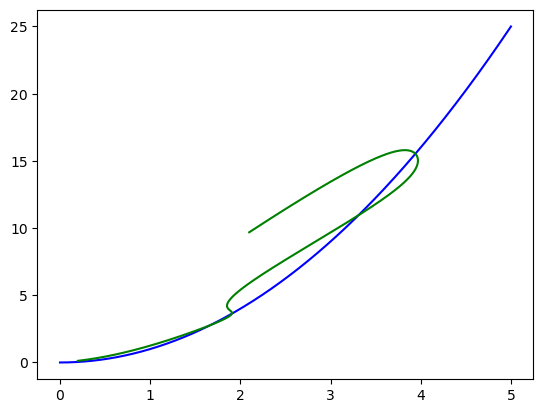

In [8]:
parameterized_function = lambda t: [f_1(t), f_2(t)]
t_range = (0, 5)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plot_harmonic_weight(uniform_samples, random_samples, 0.5, normalize=False)

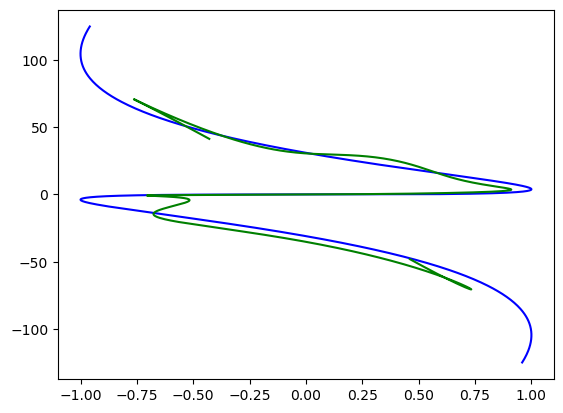

In [9]:
parameterized_function = lambda t: [f_4(t), f_3(t)]
t_range = (-5, 5)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plot_harmonic_weight(uniform_samples, random_samples, 0.5, normalize=False)

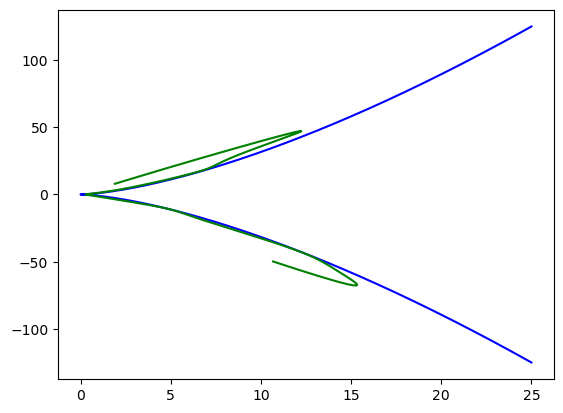

In [10]:
parameterized_function = lambda t: [f_2(t), f_3(t)]
t_range = (-5, 5)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plot_harmonic_weight(uniform_samples, random_samples, 0.5, normalize=False)

Unfortunately, there exists a tendancy for $t$ close to $t_0$ or $t_{|n|}$ to "wick" back towards the origin. We can gain some insight into the problem by plotting our sampled $x_i$ points atop the two functions.

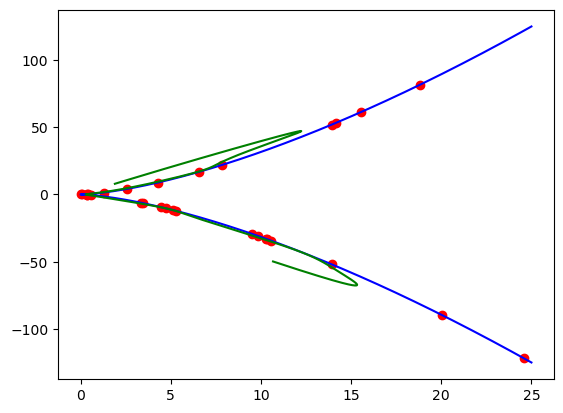

In [11]:
plot_harmonic_weight(uniform_samples, random_samples, 0.5, normalize=False)
# Also plot the sample points
plt.scatter(random_sample_points[0], random_sample_points[1], color='red')

Our approximation has the tendancy to move towards $0$ when there are not enough points within the gaussian kernel. We can see this even more clearly when we lower $\epsilon$. Observe how the function will "reach out" towards each of our sample points, before quickly moving back towards the origin.

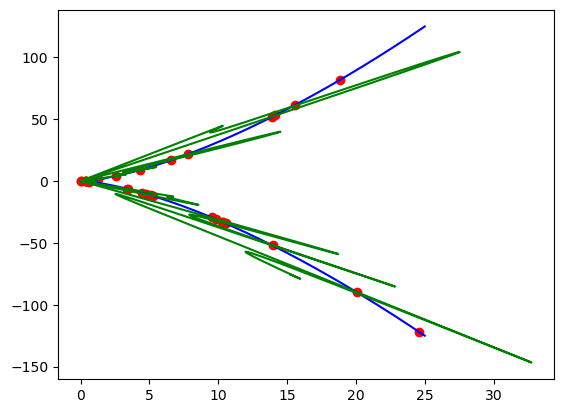

In [12]:
plot_harmonic_weight(uniform_samples, random_samples, 0.15, normalize=False)
# Also plot the sample points
plt.scatter(random_sample_points[0], random_sample_points[1], color='red')

### Example Three: KDE-like
Let's try a different method. This time, let's imagine that we use our gaussian to set the local density of the sampled points. Then, we can normalize by that value.

$$x(t) \approx \frac{\sum_{i \in [n]} \eta_\varepsilon(t - t_i) x_i}{\sum_{i \in [n]} \eta_\varepsilon(t - t_i)}$$

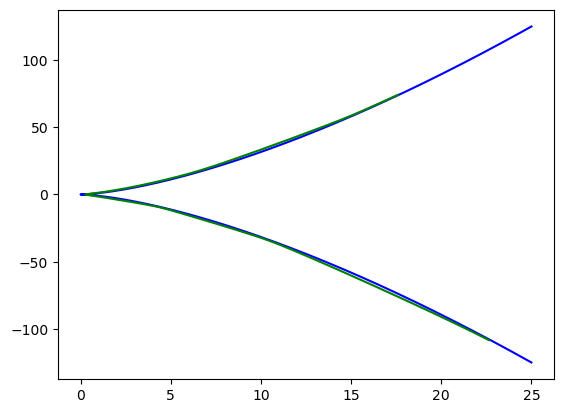

In [13]:
def plot_gaussian_normalized(uniform_samples, random_samples, kernel_size):
    # Calculate our random sample points
    random_sample_points = parameterized_function(random_samples)
    random_sample_points = torch.stack(random_sample_points).T
    # Initialize where we will store our approximated x(t) values
    gaussian_estimated_points = []
    # Iterate over our domain of t
    for t in uniform_samples:
        # Initialize where we will store our sums
        estimated_value_at_t = [0, 0]
        estimated_density_at_t = 0
        # Sum over all samples in [n] (we are running both sums simultaneously)
        for i, (t_i, x_i) in enumerate(zip(random_samples, random_sample_points)):
            # Calculate the gaussian for this sample's t value
            eta_epsilon = gaussian(t_i - t, kernel_size)
            # Multiply by x_i and add to our sum
            estimated_value_at_t[0] += eta_epsilon * x_i[0]
            estimated_value_at_t[1] += eta_epsilon * x_i[1]
            # Add to our density sum
            estimated_density_at_t += eta_epsilon
        # Perform the normalization
        estimated_value_at_t[0] /= estimated_density_at_t
        estimated_value_at_t[1] /= estimated_density_at_t
        # Add to our list of x(t) outputs
        gaussian_estimated_points.append(estimated_value_at_t)\

    # Plot both the true function and our estimated function
    gaussian_estimated_points = torch.tensor(gaussian_estimated_points).T
    plt.plot(uniform_sample_points[0], uniform_sample_points[1], color='blue')
    plt.plot(gaussian_estimated_points[0], gaussian_estimated_points[1], color='green')

plot_gaussian_normalized(uniform_samples, random_samples, 0.5)

Much better. It is also less sensitive to our choice in $\epsilon$.

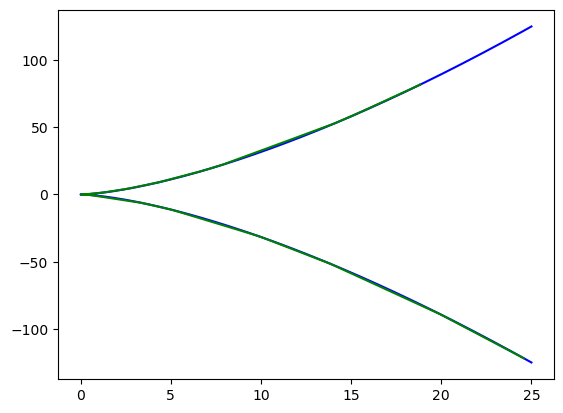

In [14]:
plot_gaussian_normalized(uniform_samples, random_samples, 0.15)

And let's try it with some of the other functions from before.

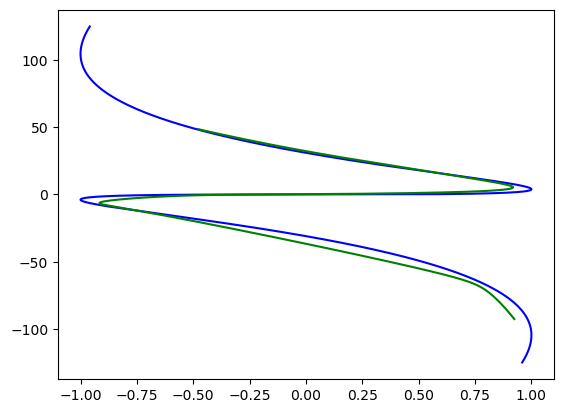

In [15]:
parameterized_function = lambda t: [f_4(t), f_3(t)]
t_range = (-5, 5)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plot_gaussian_normalized(uniform_samples, random_samples, 0.5)

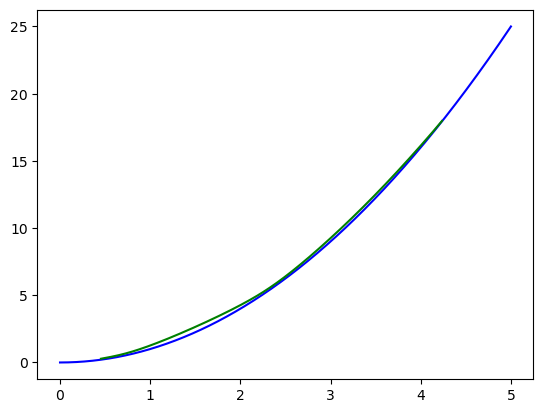

In [16]:
parameterized_function = lambda t: [f_1(t), f_2(t)]
t_range = (0, 5)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plot_gaussian_normalized(uniform_samples, random_samples, 0.5)

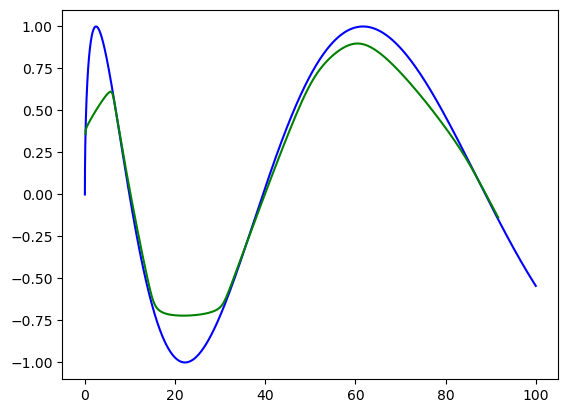

In [17]:
parameterized_function = lambda t: [f_2(t), f_4(t)]
t_range = (0, 10)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plot_gaussian_normalized(uniform_samples, random_samples, 0.5)

Much better than our previous estimates. One thing that you can notice here, however, is that there appears to be some sort of contraction occuring. The estimated function will tend toward the interior of any curves, and the ends will not extend quite as far as the true function. This will be especially troublesome if the function we want to estimate grows quickly at extreme $t$ values.

(TODO: See if there is literature examining this issue and attempts to resolve it)

Now, let's see how this functions if we add some noise to our samples. We are loosening our assumption that $x(t_i) = x_i$ back to $x(t_i) \approx x_i$.

Here I have added noise such that:

$$x_i = x(t_i) + 0.1 \cdot \mathcal{N}(0, 1) \cdot [ \max_{i \in [n]} x(t_i) - \min_{i \in [n]} x(t_i)]$$

In [18]:
parameterized_function = lambda t: [f_2(t), f_4(t)]
t_range = (0, 10)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)
# Add some noise to the sample points
x_range = torch.max(random_sample_points[0]) - torch.min(random_sample_points[0])
y_range = torch.max(random_sample_points[1]) - torch.min(random_sample_points[1])
random_sample_points[0] += torch.randn(num_samples) * x_range * 0.1
random_sample_points[1] += torch.randn(num_samples) * y_range * 0.1

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

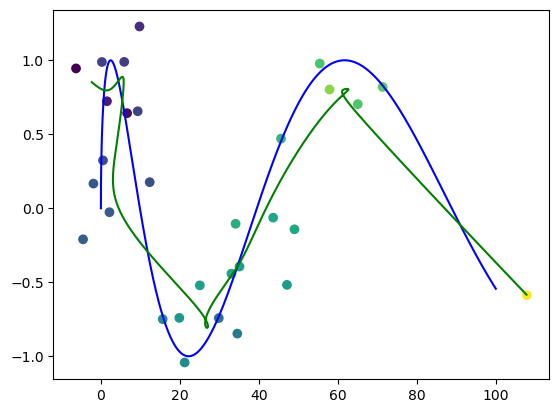

In [19]:
def plot_gaussian_normalized(uniform_samples, random_samples, random_sample_points, kernel_size):
    # Calculate our random sample points
    if isinstance(random_sample_points, list):
        random_sample_points = torch.stack(random_sample_points).T
    # Initialize where we will store our approximated x(t) values
    gaussian_estimated_points = []
    # Iterate over our domain of t
    for t in uniform_samples:
        # Initialize where we will store our sums
        estimated_value_at_t = [0, 0]
        estimated_density_at_t = 0
        # Sum over all samples in [n] (we are running both sums simultaneously)
        for i, (t_i, x_i) in enumerate(zip(random_samples, random_sample_points)):
            # Calculate the gaussian for this sample's t value
            eta_epsilon = gaussian(t_i - t, kernel_size)
            # Multiply by x_i and add to our sum
            estimated_value_at_t[0] += eta_epsilon * x_i[0]
            estimated_value_at_t[1] += eta_epsilon * x_i[1]
            # Add to our density sum
            estimated_density_at_t += eta_epsilon
        # Perform the normalization
        estimated_value_at_t[0] /= estimated_density_at_t
        estimated_value_at_t[1] /= estimated_density_at_t
        # Add to our list of x(t) outputs
        gaussian_estimated_points.append(estimated_value_at_t)

    # Plot both the true function and our estimated function
    gaussian_estimated_points = torch.tensor(gaussian_estimated_points).T
    plt.plot(uniform_sample_points[0], uniform_sample_points[1], color='blue')
    plt.plot(gaussian_estimated_points[0], gaussian_estimated_points[1], color='green')

plot_gaussian_normalized(uniform_samples, random_samples, random_sample_points, 0.5)
# Also plot the sample points, colored by their t value
plt.scatter(random_sample_points[0], random_sample_points[1], c=random_samples, cmap='viridis')

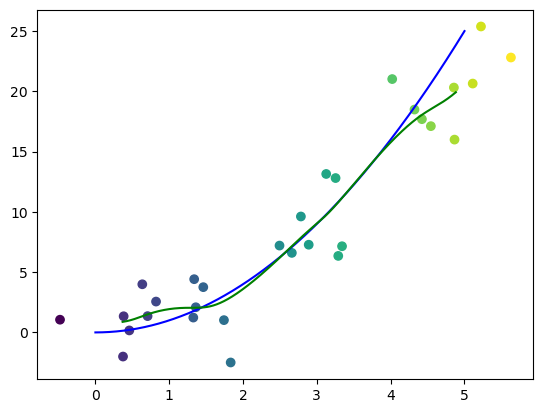

In [20]:
parameterized_function = lambda t: [f_1(t), f_2(t)]
t_range = (0, 5)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)
# Add some noise to the sample points
x_range = torch.max(random_sample_points[0]) - torch.min(random_sample_points[0])
y_range = torch.max(random_sample_points[1]) - torch.min(random_sample_points[1])
random_sample_points[0] += torch.randn(num_samples) * x_range * 0.1
random_sample_points[1] += torch.randn(num_samples) * y_range * 0.1

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plot_gaussian_normalized(uniform_samples, random_samples, random_sample_points, 0.5)
# Also plot the sample points, colored by their t value
plt.scatter(random_sample_points[0], random_sample_points[1], c=random_samples, cmap='viridis')

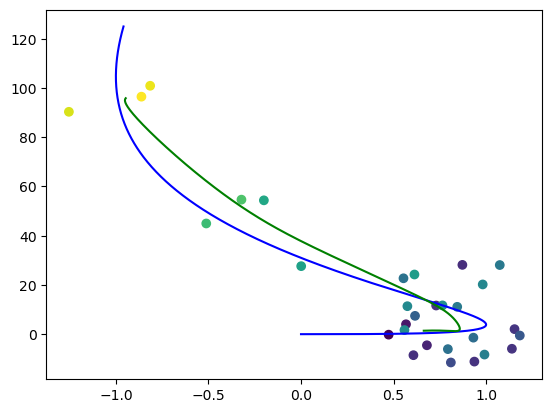

In [21]:
parameterized_function = lambda t: [f_4(t), f_3(t)]
t_range = (0, 5)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)
# Add some noise to the sample points
x_range = torch.max(random_sample_points[0]) - torch.min(random_sample_points[0])
y_range = torch.max(random_sample_points[1]) - torch.min(random_sample_points[1])
random_sample_points[0] += torch.randn(num_samples) * x_range * 0.1
random_sample_points[1] += torch.randn(num_samples) * y_range * 0.1

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

plot_gaussian_normalized(uniform_samples, random_samples, random_sample_points, 0.5)
# Also plot the sample points, colored by their t value
plt.scatter(random_sample_points[0], random_sample_points[1], c=random_samples, cmap='viridis')

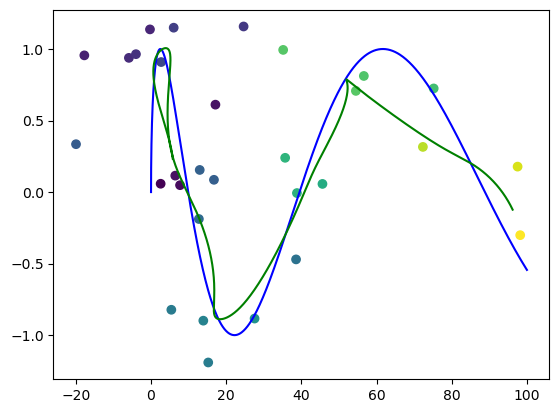

In [22]:
parameterized_function = lambda t: [f_2(t), f_4(t)]
t_range = (0, 10)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)
# Add some noise to the sample points
x_range = torch.max(random_sample_points[0]) - torch.min(random_sample_points[0])
y_range = torch.max(random_sample_points[1]) - torch.min(random_sample_points[1])
random_sample_points[0] += torch.randn(num_samples) * x_range * 0.1
random_sample_points[1] += torch.randn(num_samples) * y_range * 0.1

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)

def plot_gaussian_normalized(uniform_samples, random_samples, random_sample_points):
    # Calculate our random sample points
    if isinstance(random_sample_points, list):
        random_sample_points = torch.stack(random_sample_points).T
    # Initialize where we will store our approximated x(t) values
    gaussian_estimated_points = []
    # Iterate over our domain of t
    for t in uniform_samples:
        # Initialize where we will store our sums
        estimated_value_at_t = [0, 0]
        estimated_density_at_t = 0
        # Sum over all samples in [n] (we are running both sums simultaneously)
        for i, (t_i, x_i) in enumerate(zip(random_samples, random_sample_points)):
            # Calculate the gaussian for this sample's t value
            eta_epsilon = gaussian(t_i - t, 0.5)
            # Multiply by x_i and add to our sum
            estimated_value_at_t[0] += eta_epsilon * x_i[0]
            estimated_value_at_t[1] += eta_epsilon * x_i[1]
            # Add to our density sum
            estimated_density_at_t += eta_epsilon
        # Perform the normalization
        estimated_value_at_t[0] /= estimated_density_at_t
        estimated_value_at_t[1] /= estimated_density_at_t
        # Add to our list of x(t) outputs
        gaussian_estimated_points.append(estimated_value_at_t)

    # Plot both the true function and our estimated function
    gaussian_estimated_points = torch.tensor(gaussian_estimated_points).T
    plt.plot(uniform_sample_points[0], uniform_sample_points[1], color='blue')
    plt.plot(gaussian_estimated_points[0], gaussian_estimated_points[1], color='green')

plot_gaussian_normalized(uniform_samples, random_samples, random_sample_points)
# Also plot the sample points, colored by their t value
plt.scatter(random_sample_points[0], random_sample_points[1], c=random_samples, cmap='viridis')

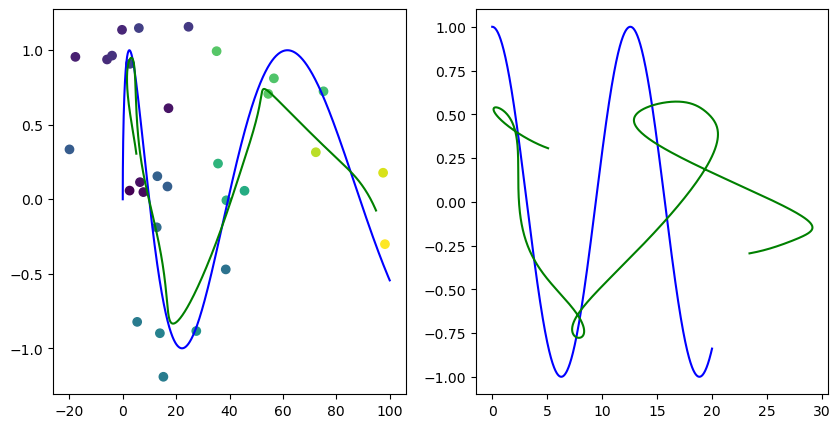

In [23]:
def plot_gaussian_normalized_exponential_velocity(uniform_samples, random_samples, uniform_sample_points, random_sample_points, velocity_values, epsilon, alpha):
    # Calculate our random sample points
    if isinstance(random_sample_points, list):
        random_sample_points = torch.stack(random_sample_points).T
    # Initialize where we will store our approximated x(t) values
    gaussian_estimated_points = []
    # Iterate over our domain of t
    for t in uniform_samples:
        # Initialize where we will store our sums
        estimated_value_at_t = [0, 0]
        estimated_density_at_t = 0
        # Sum over all samples in [n] (we are running both sums simultaneously)
        for i, (t_i, x_i) in enumerate(zip(random_samples, random_sample_points)):
            # Calculate the gaussian for this sample's t value
            eta_epsilon = gaussian(t_i - t, epsilon)
            # Multiply by x_i and add to our sum
            estimated_value_at_t[0] += eta_epsilon * x_i[0]
            estimated_value_at_t[1] += eta_epsilon * x_i[1]
            # Add to our density sum
            estimated_density_at_t += eta_epsilon
        # Perform the normalization
        estimated_value_at_t[0] /= estimated_density_at_t
        estimated_value_at_t[1] /= estimated_density_at_t
        # Add to our list of x(t) outputs
        gaussian_estimated_points.append(estimated_value_at_t)

    # Calculate the velocities
    estimated_velocity_values = []
    step_size = uniform_samples[1] - uniform_samples[0]
    for t, x in zip(uniform_samples, gaussian_estimated_points):
        estimated_exponential_term_at_t = [0, 0]
        for s, x_i in zip(uniform_samples, gaussian_estimated_points):
            if s >= t:
                break
            exponential_term = torch.exp(-alpha * (t - s))
            estimated_exponential_term_at_t[0] += exponential_term * x_i[0] * step_size
            estimated_exponential_term_at_t[1] += exponential_term * x_i[1] * step_size
        # Take the difference between the current point and the estimated exponential term multiplied by alpha
        estimated_velocity_values.append([x[0] - estimated_exponential_term_at_t[0] * alpha,
                                            x[1] - estimated_exponential_term_at_t[1] * alpha])
        
    # Create two figures, one for the position and one for the velocity
    # make it double wide
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot both the true function and our estimated function along with points on the position plot
    gaussian_estimated_points = torch.tensor(gaussian_estimated_points).T
    ax1.plot(uniform_sample_points[0], uniform_sample_points[1], color='blue')
    ax1.plot(gaussian_estimated_points[0], gaussian_estimated_points[1], color='green')
    # Undo the sample point transposition
    random_sample_points = random_sample_points.T
    ax1.scatter(random_sample_points[0], random_sample_points[1], c=random_samples, cmap='viridis')

    # Plot the velocity
    estimated_velocity_values = torch.tensor(estimated_velocity_values).T
    ax2.plot(velocity_values[0], velocity_values[1], color='blue')
    ax2.plot(estimated_velocity_values[0], estimated_velocity_values[1], color='green')

def velocity_function(t):
    return [2 * t, torch.cos(t)]
velocity_values = velocity_function(uniform_samples)


plot_gaussian_normalized_exponential_velocity(uniform_samples, random_samples, uniform_sample_points, random_sample_points, velocity_values, 0.6, 0.6)

Let's also try taking the derivate of our normalized gaussian approximation directly.

$$x(t) \approx \frac{\sum_{i \in [n]} \eta_\varepsilon(t - t_i) x_i}{\sum_{i \in [n]} \eta_\varepsilon(t - t_i)}$$

We get the admittedly ugly equation

$$v(t) = \frac{\partial x}{\partial t} x(t) \approx \frac{1}{\epsilon^2} \frac{(\sum{i \in [n]} (t_i - t)h(t_i - t) x_i) (\sum{i \in [n]} h(t_i - t)) - (\sum{i \in [n]} (t_i - t)h(t_i - t))(\sum{i \in [n]} h(t_i - t)x_i)}{(\sum{i \in [n]} h(t_i - t))^2}$$

where $h(x) = e^{-\frac{x^2}{2\epsilon^2}}$

Luckily, this is still easily computable. If we run all the sums in the same loop, then it'll be $O(n)$, despite how it looks.

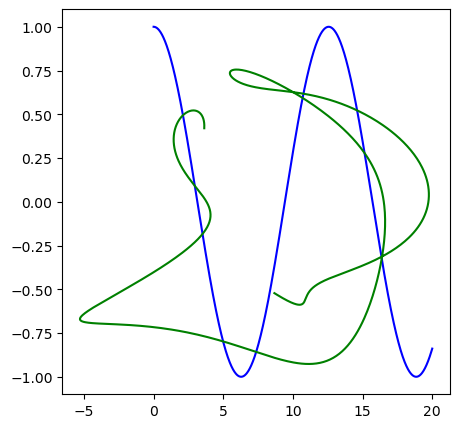

In [110]:
def exponential_component(x, epsilon):
    return torch.exp(-(x**2 / (2 * epsilon**2)))

def plot_gaussian_normalized_velocity(uniform_samples, random_samples, random_sample_points, velocity_values, epsilon):
    # Calculate our random sample points
    if isinstance(random_sample_points, list):
        random_sample_points = torch.stack(random_sample_points).T
    # Initialize where we will store our approximated v(t) values
    gaussian_estimated_velocities = []
    # Iterate over our domain of t
    for t in uniform_samples:
        # Initialize where we will store our sums
        f = [0, 0]
        f_prime = [0, 0]
        g = 0
        g_prime = 0
        # Sum over all samples in [n] (we are running all sums simultaneously)
        for t_i, x_i in zip(random_samples, random_sample_points):
            difference = t_i - t
            exponential_term = exponential_component(difference, epsilon)
            exponential_difference_product = difference * exponential_term

            # Update our sums
            f[0] += exponential_term * x_i[0]
            f[1] += exponential_term * x_i[1]
            f_prime[0] += exponential_difference_product * x_i[0]
            f_prime[1] += exponential_difference_product * x_i[1]   
            g += exponential_term 
            g_prime += exponential_difference_product

        # Perform the calculation
        velocity = [
            (f_prime[0] * g - g_prime * f[0]) / (g**2),
            (f_prime[1] * g - g_prime * f[1]) / (g**2)
        ]
        velocity[0] /= epsilon**2
        velocity[1] /= epsilon**2
        # Add to our list of v(t) outputs
        gaussian_estimated_velocities.append(velocity)

    # Create a figure for the velocity
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # Plot both the true function and our estimated function
    gaussian_estimated_velocities = torch.tensor(gaussian_estimated_velocities).T
    ax.plot(velocity_values[0], velocity_values[1], color='blue')
    ax.plot(gaussian_estimated_velocities[0], gaussian_estimated_velocities[1], color='green')

parameterized_function = lambda t: [f_2(t), f_4(t)]
t_range = (0, 10)

num_samples = 30
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)
# Add some noise to the sample points
x_range = torch.max(random_sample_points[0]) - torch.min(random_sample_points[0])
y_range = torch.max(random_sample_points[1]) - torch.min(random_sample_points[1])
random_sample_points[0] += torch.randn(num_samples) * x_range * 0.1
random_sample_points[1] += torch.randn(num_samples) * y_range * 0.1

def velocity_function(t):
    return [2 * t, torch.cos(t)]
velocity_values = velocity_function(uniform_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)
plot_gaussian_normalized_velocity(uniform_samples, random_samples, random_sample_points, velocity_values, 0.6)

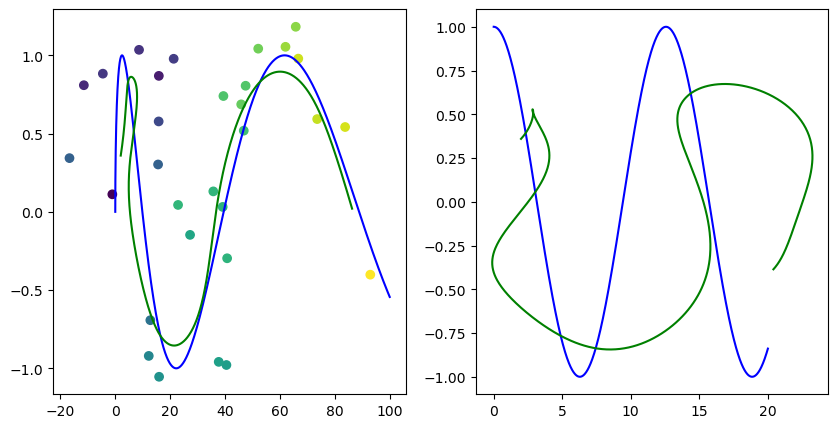

In [111]:
plot_gaussian_normalized_exponential_velocity(uniform_samples, random_samples, uniform_sample_points, random_sample_points, velocity_values, 0.6, 0.6)

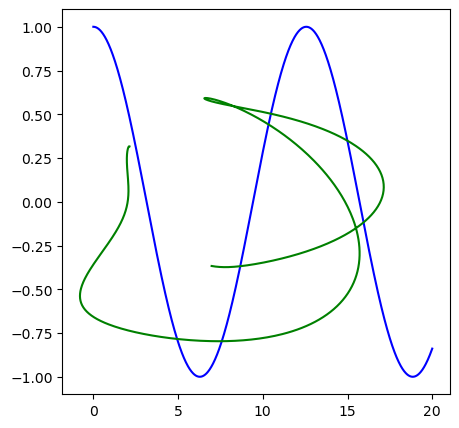

In [112]:
plot_gaussian_normalized_velocity(uniform_samples, random_samples, random_sample_points, velocity_values, 0.8)

tensor(0.0002) tensor(0.2644)


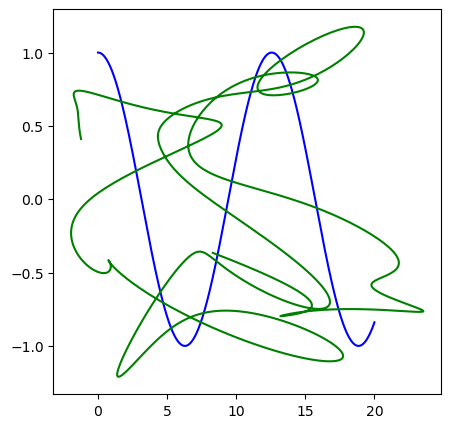

In [124]:
parameterized_function = lambda t: [f_2(t), f_4(t)]
t_range = (0, 10)

num_samples = 200
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)
# Add some noise to the sample points
x_range = torch.max(random_sample_points[0]) - torch.min(random_sample_points[0])
y_range = torch.max(random_sample_points[1]) - torch.min(random_sample_points[1])
random_sample_points[0] += torch.randn(num_samples) * x_range * 0.05
random_sample_points[1] += torch.randn(num_samples) * y_range * 0.05

def velocity_function(t):
    return [2 * t, torch.cos(t)]
velocity_values = velocity_function(uniform_samples)

differences = random_samples[1:] - random_samples[:-1]
print(min(differences), max(differences))

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)
plot_gaussian_normalized_velocity(uniform_samples, random_samples, random_sample_points, velocity_values, max(differences))

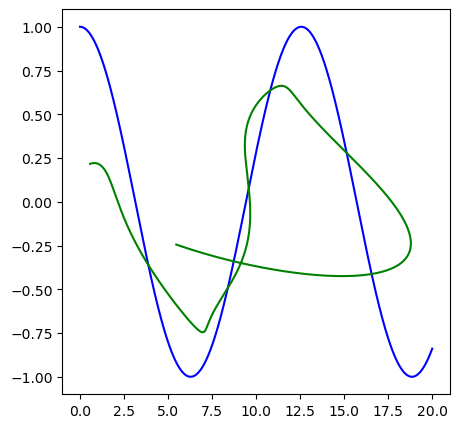

In [126]:
plot_gaussian_normalized_velocity(uniform_samples, random_samples, random_sample_points, velocity_values, 0.8)

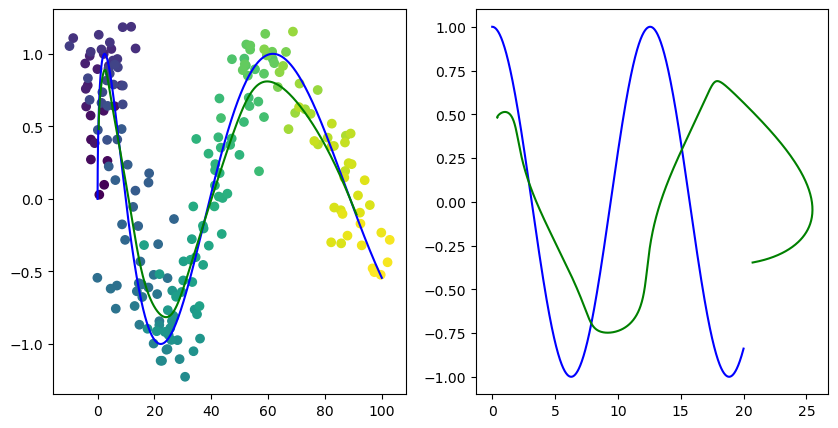

In [125]:
plot_gaussian_normalized_exponential_velocity(uniform_samples, random_samples, uniform_sample_points, random_sample_points, velocity_values, 0.6, 0.6)

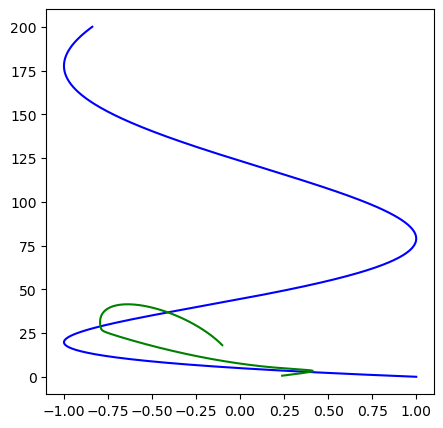

In [116]:
parameterized_function = lambda t: [f_4(t), f_3(t)]
t_range = (0, 5)

num_samples = 200
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)
# Add some noise to the sample points
x_range = torch.max(random_sample_points[0]) - torch.min(random_sample_points[0])
y_range = torch.max(random_sample_points[1]) - torch.min(random_sample_points[1])
random_sample_points[0] += torch.randn(num_samples) * x_range * 0.1
random_sample_points[1] += torch.randn(num_samples) * y_range * 0.1

def velocity_function(t):
    return [torch.cos(t), 2 * (t**2)]
velocity_values = velocity_function(uniform_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)
plot_gaussian_normalized_velocity(uniform_samples, random_samples, random_sample_points, velocity_values, 0.6)

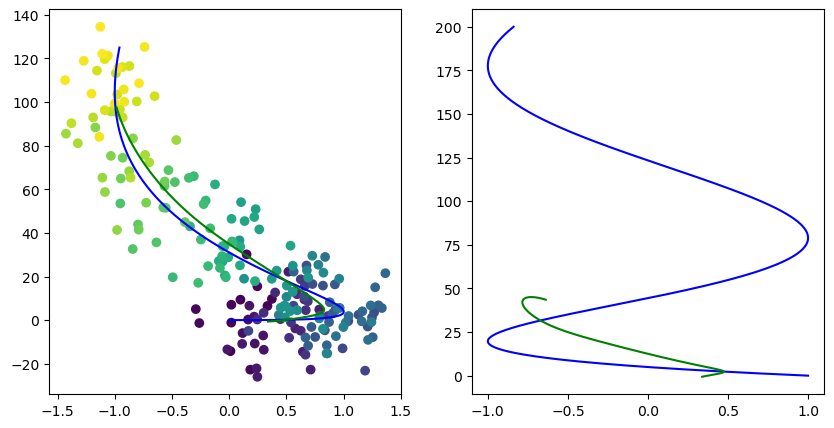

In [117]:
plot_gaussian_normalized_exponential_velocity(uniform_samples, random_samples, uniform_sample_points, random_sample_points, velocity_values, 0.6, 0.6)

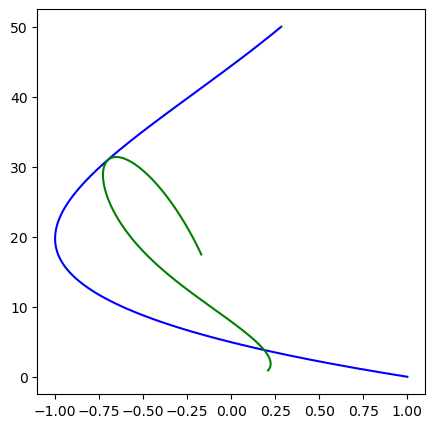

In [88]:
parameterized_function = lambda t: [f_4(t), f_3(t)]
t_range = (0, 5)

num_samples = 1000
random_samples = torch.rand(num_samples) * (t_range[1] - t_range[0]) + t_range[0]
# Now order the random samples
random_samples, _ = torch.sort(random_samples)
random_sample_points = parameterized_function(random_samples)
# Add some noise to the sample points
x_range = torch.max(random_sample_points[0]) - torch.min(random_sample_points[0])
y_range = torch.max(random_sample_points[1]) - torch.min(random_sample_points[1])
random_sample_points[0] += torch.randn(num_samples) * x_range * 0.1
random_sample_points[1] += torch.randn(num_samples) * y_range * 0.1

def velocity_function(t):
    return [torch.cos(t), 2 * (t**2)]
velocity_values = velocity_function(uniform_samples)

num_samples = 1000
uniform_samples = torch.linspace(t_range[0], t_range[1], num_samples)
uniform_sample_points = parameterized_function(uniform_samples)
plot_gaussian_normalized_velocity(uniform_samples, random_samples, random_sample_points, velocity_values, 0.6)

## Question Two: Approximation Errors of the Exponential Term

(IN PROGRESS)

In [ ]:
def f1(ti: float, t: float, a: float, e: float) -> float:
    steps = 1000000
    neg_inf = -1000
    s = torch.linspace(neg_inf, t, steps)
    step_size = (t - neg_inf) / steps
    expo = torch.exp(-a * (t - s))
    gauss = gaussian(s - ti, e)
    return torch.sum(expo * gauss) * step_size


def f2(ti: float, t: float, a: float, e: float) -> float:
    return torch.exp(-a * (t - ti)) * (ti <= t)

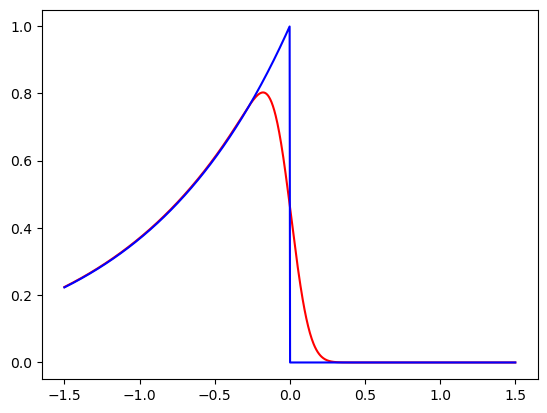

In [ ]:
t = 0
a = 1.0
e = 0.1

window_size = 3

ti = torch.linspace(- window_size/2, window_size/2, 1000)

f1_output = [f1(_t, t, a, e) for _t in ti]
f2_output = [f2(_t, t, a, e) for _t in ti]

plt.plot(ti, f1_output, color='red')
plt.plot(ti, f2_output, color='blue')